In [188]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import math

# TEST ASSUMPTIONS
import statsmodels.stats.api as sms # homoskedasticity
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white # homoskedasticity
from scipy.stats import bartlett # homoskedasticity
from scipy.stats import normaltest # for normal distribution
from statsmodels.stats import diagnostic as diag # autocorellation (not so important)
import statsmodels.api as sm # autocorellation (not so important)

# LASSO model selection
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso

# CREATED FUNCTIONS
from ufc_func import *

# OUTLIERS
from scipy import stats

In [104]:
df = pd.read_csv("./ufc.csv")
df = pd.DataFrame(df)
df

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith
7413,"Denver, Colorado, USA",Frank Hamaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Morris
7414,"Denver, Colorado, USA",Johnny Rhodes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7415,"Denver, Colorado, USA",Patrick Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our dataframe contains some null rows, so will need to remove it. Additionally column with "Time" doesn't useful for our aims in this represantation. We need to convert it to another units (to seconds).

In [105]:
df = df.dropna()
df_with_time = df.copy()

df_with_time["Seconds"] = df_with_time["Time"].apply(time_converter) + df_with_time["Round"].apply(round_converter)
df_with_time


,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan,64.0
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner,169.0
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo,900.0
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady,703.0
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0


Also some there are some "strange" fights: fighter 1 and fighter 2 both loss in fight.

In [106]:
df_with_time.tail(10)

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
7403,"Denver, Colorado, USA",Royce Gracie,Fred Ettish,1.0,0.0,13.0,4.0,0.0,0.0,1.0,0.0,Open Weight,SUB Bulldog Choke,1.0,3:07,UFC 2,11-Mar-94,Remco Pardoel,187.0
7404,"Denver, Colorado, USA",Patrick Smith,Scott Morris,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,Open Weight,KO/TKO Elbows,1.0,0:30,UFC 2,11-Mar-94,Johnny Rhodes,30.0
7405,"Denver, Colorado, USA",Royce Gracie,Minoki Ichihara,0.0,0.0,2.0,3.0,1.0,0.0,2.0,0.0,Open Weight,SUB Armbar,1.0,5:08,UFC 2,11-Mar-94,Patrick Smith,308.0
7406,"Denver, Colorado, USA",Remco Pardoel,Scott Baker,0.0,0.0,3.0,0.0,0.0,1.0,5.0,0.0,Open Weight,SUB Triangle Choke,1.0,6:41,UFC 2,11-Mar-94,Royce Gracie,401.0
7407,"Denver, Colorado, USA",Johnny Rhodes,Alberta Cerra Leon,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,Open Weight,SUB Ezekiel Choke,1.0,9:51,UFC 2,11-Mar-94,Jason DeLucia,591.0
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith,20.0


We need to remove it

In [107]:
df_with_time = df_with_time.loc[
    (df_with_time["Fighter 1"] == df_with_time["Winner"]) | 
    (df_with_time["Fighter 1"] == df_with_time["Winner"])].reset_index(drop=True)

Next, let us show average statistic per fight (including first and second fighter)

In [108]:
total_kd = (df["Fighter_1_KD"] + df["Fighter_2_KD"]).mean()
total_str= (df["Fighter_1_STR"] + df["Fighter_2_STR"]).mean()
total_td= (df["Fighter_1_TD"] + df["Fighter_2_TD"]).mean()
total_sub= (df["Fighter_1_SUB"] + df["Fighter_1_SUB"]).mean()

print("Average knockdowns per fight: ", total_kd)
print("Average significant strikes per fight: ", total_str)
print("Average takedown attemps per fight: ", total_td)
print("Average submissions attemps per fight: ", total_sub)

Average knockdowns per fight:  0.4305180787911495
Average significant strikes per fight:  71.68497031840259
Average takedown attemps per fight:  2.1184565569347007
Average submissions attemps per fight:  1.0642201834862386


In [109]:
arman = df.loc[(df["Fighter 2"] == "Arman Tsarukyan")]
arman2 = df.loc[(df["Fighter 1"] == "Arman Tsarukyan")]
round((arman["Fighter_2_KD"].mean() + arman2["Fighter_1_KD"].mean())/2, 2)

0.38

As we can see knockdowns is the rarest fight moment. Now let us look what type of finishes UFC fight can have:

In [110]:
methods = df_with_time["Method"].unique()

methods

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'Overturned', 'KO/TKO Elbows',
       'KO/TKO Kick', 'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC',
       'SUB Arm Triangle', 'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'DQ',
       'SUB Anaconda Choke', 'SUB Ezekiel Choke', 'SUB Triangle Choke',
       'SUB Twister', 'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'Overturned Guillotine Choke',
       'KO/TKO Elbow', 'SUB Other - Lock', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'Overturned Punches',
       'SUB Ankle Lock', 'SUB Forearm Choke', 'SUB Injury',
       'Overturned Punch', 'Overturned Rear Naked Choke',
       'Overturned Knee', 'O

There are lots of different type of finishes, but all them come down to KO/TKO, SUB, DEC, CNC. Overturned, Other and DQ are useless characteristic for our research.

In [111]:
df_fil = methods_destroyer(df_with_time)

df_fil["Method"].unique()

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'KO/TKO Elbows', 'KO/TKO Kick',
       'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC', 'SUB Arm Triangle',
       'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'SUB Anaconda Choke',
       'SUB Ezekiel Choke', 'SUB Triangle Choke', 'SUB Twister',
       'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'KO/TKO Elbow', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'SUB Ankle Lock',
       'SUB Forearm Choke', 'SUB Injury', 'SUB Peruvian Necktie',
       'SUB Schultz Front Headlock', 'SUB Bulldog Choke',
       'SUB Suloev Stretch', 'SUB Omoplata', 'SUB Calf Slicer',
       'SUB North-South Choke', 'SUB Pac

Now this data can be useful, we can plot distribution of methods if we remove additional information, like "Armbar", "Punch" and so on.

In [112]:
df_methods = df_fil.copy()
df_methods["Method"] = df_fil["Method"].apply(replace_method)
df_methods["Method"].unique()

array(['KO/TKO', 'DEC', 'SUB'], dtype=object)

Now we can plot histogram of distribtuion

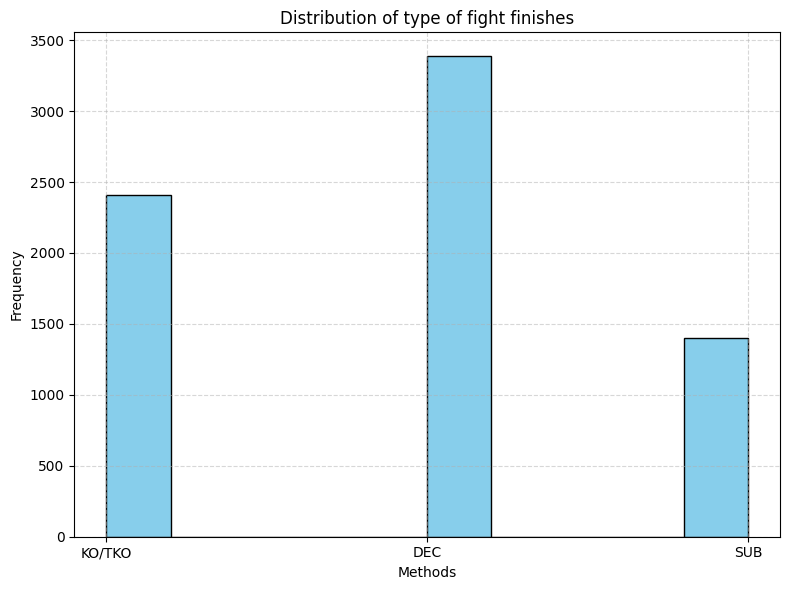

In [113]:
plt.figure(figsize=(8, 6))
plt.hist(df_methods["Method"], color='skyblue', edgecolor='black')
plt.title('Distribution of type of fight finishes')
plt.xlabel('Methods')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Now let us take a look at "Weight_Class".

In [114]:
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       'Catch Weight', "Women's Featherweight", 'Super Heavyweight',
       'Open Weight'], dtype=object)

Some of these categories are not used in UFC, so we will drop them 

In [115]:
df_fil = weight_destroyer(df_fil)
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       "Women's Featherweight"], dtype=object)

Now it will be good to remove 5 rounds fight (championship fightr), because it has low fraction in all data, and it will make our model for prediction fight duration more bias.

In [116]:
three, five = df_breaker_by_rounds(df_fil)

df_fil = three.copy()

df_fil

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan,64.0
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner,169.0
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo,900.0
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady,703.0
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,"Mobile, Alabama, USA",Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,Middleweight,S-DEC,2.0,3:00,UFC 17,15-May-98,Dan Henderson,480.0
7263,"Mobile, Alabama, USA",David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,Heavyweight,KO/TKO Punches,1.0,0:43,UFC 17,15-May-98,David Abbott,43.0
7264,"Mobile, Alabama, USA",Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,Heavyweight,SUB Keylock,1.0,11:01,UFC 17,15-May-98,Mike van Arsdale,661.0
7265,"Mobile, Alabama, USA",Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,Middleweight,SUB Triangle Choke,1.0,0:52,UFC 17,15-May-98,Carlos Newton,52.0


Now, we are going to remove all unneccassary columns: Date (data doesn't depend on date), Event Name, Round, Time, Location.

In [117]:
df_fil = de_remover(df_fil)

Now it will be good to remove 5 rounds fight (championship fightr), because it has low fraction in all data, and it will make our model for prediction fight duration more bias.

Finally, our dataframe is ready to be used in project. But before, we will run logit and OLS models, let us create dataframe with fighters statistic.

In [118]:
fighters = list(set(df_fil["Fighter 1"].unique()).union(set(df_fil["Fighter 2"].unique())))
fighters_df = pd.DataFrame({"Fighter_name": [],
                            "Average_significant_strikes": [],
                            "Average_takedowns": [],
                            "Average_submission_attempts": [],
                            "Average_knockdowns": [],
                            "Average_activity": [],
                            "Wins": [],
                            "Loss": [],
                            "Winrate": []})


for ele in fighters:
    win_df = df_fil.loc[df_fil["Fighter 1"] == ele]
    lose_df = df_fil.loc[df_fil["Fighter 2"] == ele]

    wins, losses = int(len(win_df.index)), int(len(lose_df.index))

    amount_of_mentions = wins + losses

    avg_strk = round((win_df["Fighter_1_STR"].sum() + lose_df["Fighter_2_STR"].sum())/amount_of_mentions, 2)
    avg_tkd = round((win_df["Fighter_1_TD"].sum() + lose_df["Fighter_2_TD"].sum())/amount_of_mentions, 2)
    avg_subs = round((win_df["Fighter_1_SUB"].sum() + lose_df["Fighter_2_SUB"].sum())/amount_of_mentions, 2)
    avg_kd = round((win_df["Fighter_1_KD"].sum() + lose_df["Fighter_2_KD"].sum())/amount_of_mentions, 2)
    avg_act = avg_strk + avg_tkd + avg_subs + avg_kd

    data = {
        "Fighter_name": [ele],
        "Average_significant_strikes": [avg_strk],
        "Average_takedowns": [avg_tkd],
        "Average_submission_attempts": [avg_subs],
        "Average_knockdowns": [avg_kd],
        "Average_activity": [avg_act],
        "Wins": [wins],
        "Loss": [losses],
        "Winrate": [round(wins/(wins+losses), 2)]
    }

    fighters_df = pd.concat([fighters_df, pd.DataFrame(data)], ignore_index = True)

fighters_df

,Fighter_name,Average_significant_strikes,Average_takedowns,Average_submission_attempts,Average_knockdowns,Average_activity,Wins,Loss,Winrate
0,Justin Ledet,31.14,0.14,0.14,0.00,31.42,3.0,4.0,0.43
1,Devin Clark,33.44,1.75,0.06,0.19,35.44,8.0,8.0,0.50
2,Rinya Nakamura,23.50,2.00,1.50,1.00,28.00,2.0,0.0,1.00
3,Tresean Gore,25.00,1.67,0.67,0.00,27.34,1.0,2.0,0.33
4,Ian McCall,57.67,1.83,0.00,0.00,59.50,2.0,4.0,0.33
...,...,...,...,...,...,...,...,...,...
2308,Abdul-Kerim Edilov,77.00,2.00,1.00,0.00,80.00,1.0,0.0,1.00
2309,Matt Serra,23.79,1.64,0.71,0.36,26.50,7.0,7.0,0.50
2310,Jacob Kilburn,33.50,0.50,0.50,0.00,34.50,0.0,2.0,0.00
2311,Ben Wall,2.50,0.00,0.00,0.00,2.50,0.0,2.0,0.00


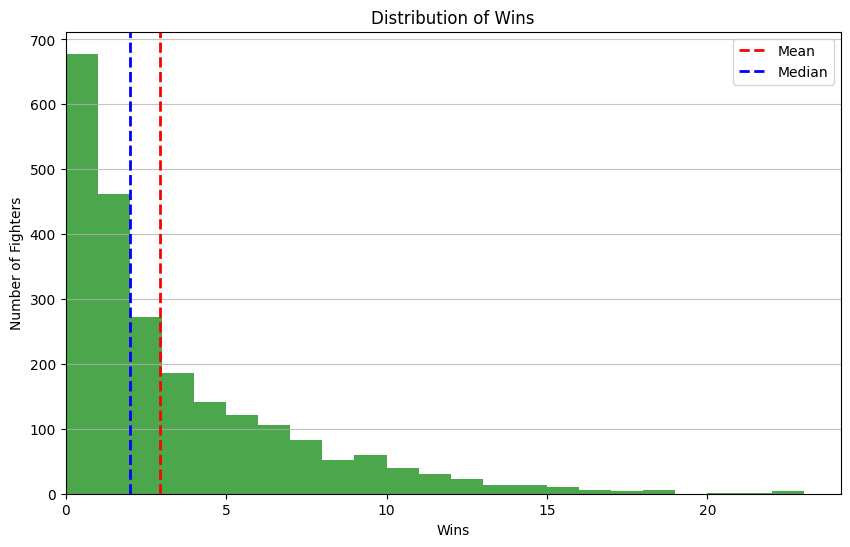

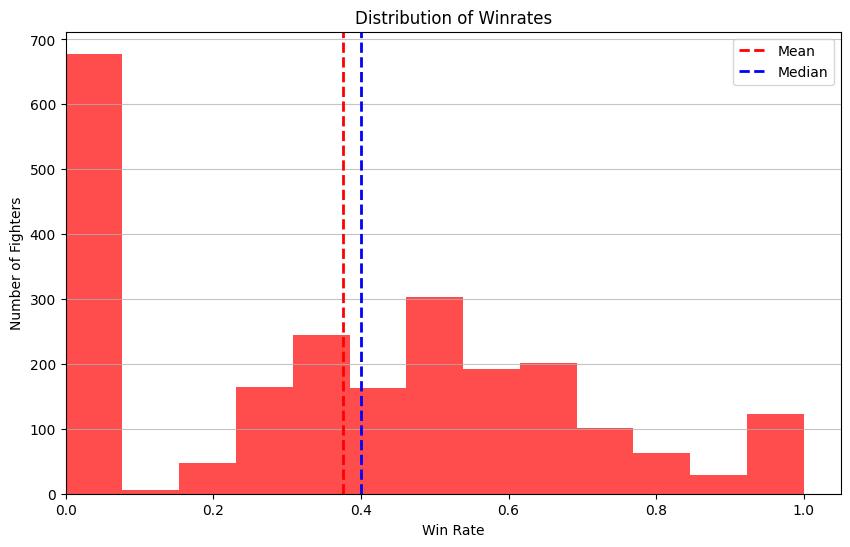

In [119]:
mean_wins = fighters_df["Wins"].mean()
median_wins = fighters_df["Wins"].median()

plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Wins"], bins=int(fighters_df["Wins"].max()), color='green', alpha=0.7)
plt.title('Distribution of Wins')
plt.xlabel('Wins')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wins, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wins, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()

plt.show()

mean_wr = fighters_df["Winrate"].mean()
median_wr = fighters_df["Winrate"].median()
plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Winrate"], bins='auto', color='red', alpha=0.7)
plt.title('Distribution of Winrates')
plt.xlabel('Win Rate')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wr, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wr, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()
plt.show()

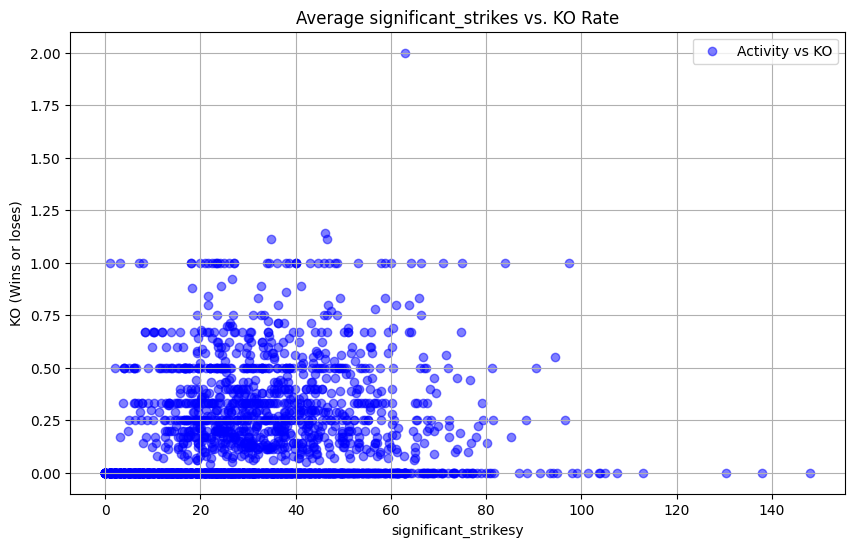

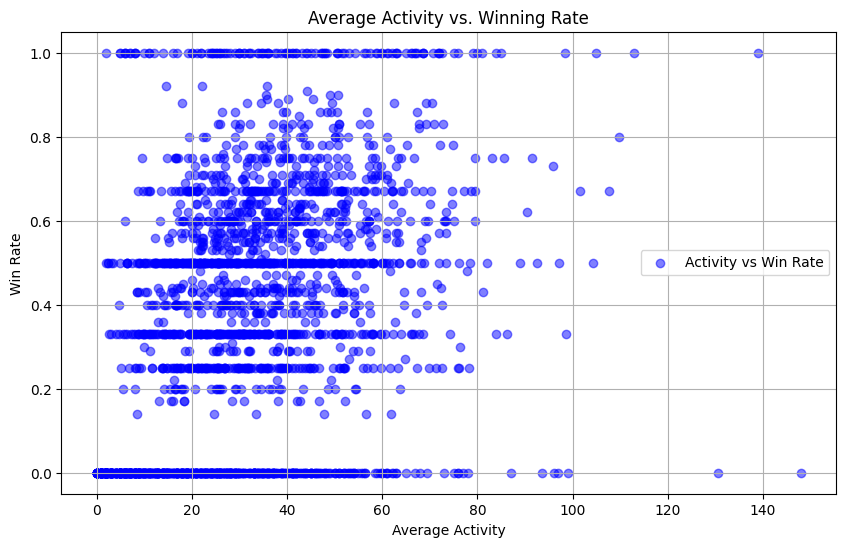

In [120]:
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_significant_strikes"], fighters_df["Average_knockdowns"], color='blue', alpha=0.5, label='Activity vs KO')
plt.title('Average significant_strikes vs. KO Rate')
plt.xlabel('significant_strikesy')
plt.ylabel('KO (Wins or loses)')
plt.legend()
plt.grid(True)
plt.show()

# Improved Scatter plot for Average Activity vs. Win Rate
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_activity"], fighters_df["Winrate"], color='blue', alpha=0.5, label='Activity vs Win Rate')
plt.title('Average Activity vs. Winning Rate')
plt.xlabel('Average Activity')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)
plt.show()

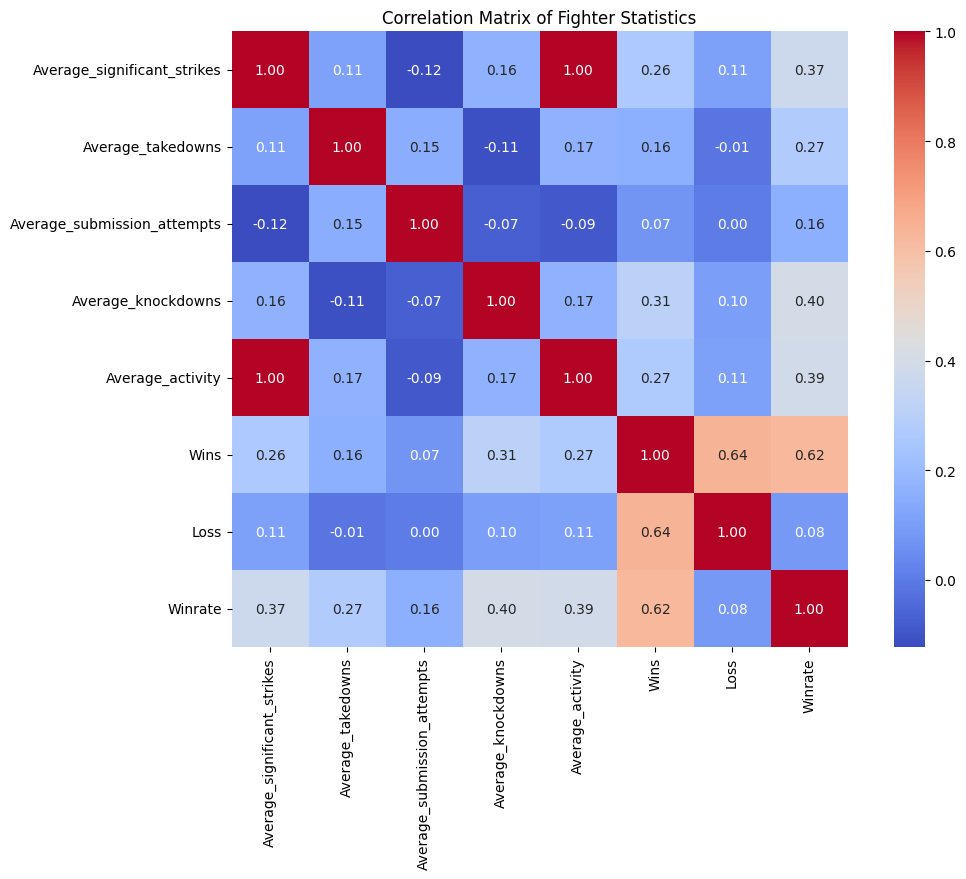

In [121]:
cor_df = fighters_df.drop(["Fighter_name"], axis=1)
correlation_matrix = cor_df.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title('Correlation Matrix of Fighter Statistics')
plt.show()

# OLS

Now, we are going to construct OLS method for predicting the duration of fight in seconds. However, our dataframe contains male and female fighters and it is not relevant to predict duration fight in combined dataframe, because man and woman can not have much up in UFC, so we are going to divide dataframe in two: for males and for females

In [122]:
df_fil["Gender"] = np.where(df_fil["Weight_Class"].str.contains("Women"), 1, 0)
df_man = df_fil.loc[df_fil["Gender"] == 0].drop(["Gender"], axis=1).reset_index(drop=True)
df_woman = df_fil.loc[df_fil["Gender"] != 0].drop(["Gender"], axis=1).reset_index(drop=True)

Variables in "Weight_Class" is ordinal, so to make our future OLS more relevent, we need to divide this column to many distinct columns. Each this column will represent the distinct weight category, so if fighters belong to this category we will put 1, if not 0 (It is clear that fighters in one fight can only belongs to one category).

In [123]:
df_man_clear = weight_breaker(df_man)
df_woman_clear = weight_breaker(df_woman)

df_man_clear

,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Winner,Seconds,Lightweight,Bantamweight,Welterweight,Middleweight,Light Heavyweight,Featherweight,Heavyweight,Flyweight
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,Arman Tsarukyan,64.0,1,0,0,0,0,0,0,0
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,Jalin Turner,169.0,1,0,0,0,0,0,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,Deiveson Figueiredo,900.0,0,1,0,0,0,0,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,Sean Brady,703.0,0,0,1,0,0,0,0,0
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,Joaquim Silva,900.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,Dan Henderson,480.0,0,0,0,1,0,0,0,0
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,David Abbott,43.0,0,0,0,0,0,0,1,0
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,Mike van Arsdale,661.0,0,0,0,0,0,0,1,0
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,Carlos Newton,52.0,0,0,0,1,0,0,0,0


In [124]:
winrates_df = history_winrate(df_man_clear)

In [125]:


names = [ele.replace(" ", "_") for ele in winrates_df.columns.to_list()]
winrates_df.columns = names

winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Lightweight,Bantamweight,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.88,0.77
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.59
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0.75,0.75
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,0,0,1,0,0,0,0,0,0.83,0.75
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,0,0,1,0,0,0,0,1.00,1.00
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,0,0,1,0,0,0,0,0.00,0.00


In [126]:
categories_all = [ele for ele in winrates_df.columns if "Fighter" in ele or "winrate" in ele]
categories = [(categories_all[i], categories_all[i+1]) for i in range(0, len(categories_all), 2)]

swapper(winrates_df, categories)



We have lots of zeroes in this dataframe so let us try to remove them or make more meaningful

In [127]:
winrates_df['Winrate_1_is_0'] = np.where(winrates_df["Current_winrate_F1"] == 0, 1, 0)
winrates_df['Winrate_2_is_0'] = np.where(winrates_df["Current_winrate_F2"] == 0, 1, 0)

In [128]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.88,0.77,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Kelvin Gastelum,Sean Brady,0.0,0.0,18.0,14.0,0.0,5.0,0.0,3.0,...,1,0,0,0,0,0,0.75,0.83,0,0
4,Clay Guida,Joaquim Silva,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Carlos Newton,Dan Henderson,2.0,0.0,20.0,28.0,2.0,3.0,1.0,0.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,Hugo Duarte,David Abbott,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# OLS

In [129]:
winrates_df_model = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1).copy()

model_Time=smf.ols(f"Seconds ~ {' + '.join(winrates_df_model)}", data=winrates_df)
print(model_Time.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     581.0
Date:                Tue, 16 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:02:52   Log-Likelihood:                -41059.
No. Observations:                6136   AIC:                         8.216e+04
Df Residuals:                    6116   BIC:                         8.229e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            175.2877     15

Now It is seem that weight class in unsignificant variable, so let test their joint significance

In [130]:
weights = winrates_df[['Bantamweight', 'Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight']]

test_model = smf.ols(formula=f"Seconds ~ {' + '.join(weights.columns)}", data=winrates_df).fit()

f_statistic = test_model.fvalue
p_value = test_model.f_pvalue


if p_value < 0.05:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


It seems their are significant. Now let perform model selection with AIC to create the best model

In [131]:
# LASSO SELECTION IS DONE
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(winrates_df_model, winrates_df["Seconds"])
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


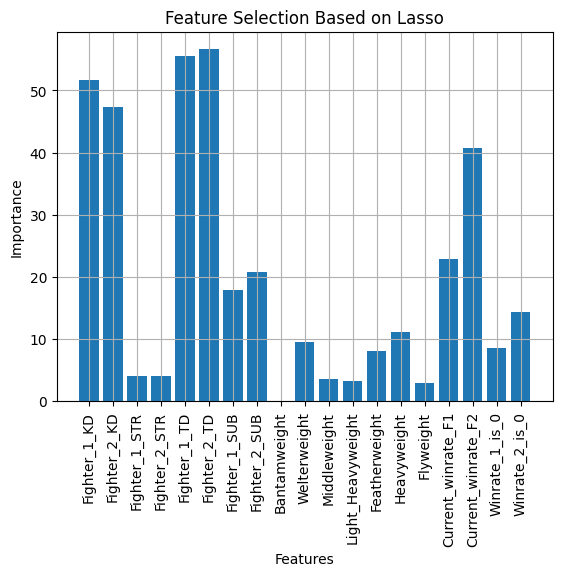

In [132]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(winrates_df_model, winrates_df["Seconds"])

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

names = winrates_df_model.columns
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [133]:
feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))

# Adding the target to the list of feaatures. 
feature_subset=np.append(feature_subset, "Outcome")
print("Selected Columns: {}".format(feature_subset))

selected_model = winrates_df_model[np.array(names)[lasso1_coef>3]]

selected_model

Selected Feature Columns: ['Fighter_1_KD' 'Fighter_2_KD' 'Fighter_1_STR' 'Fighter_2_STR'
 'Fighter_1_TD' 'Fighter_2_TD' 'Fighter_1_SUB' 'Fighter_2_SUB'
 'Bantamweight' 'Welterweight' 'Middleweight' 'Light_Heavyweight'
 'Featherweight' 'Heavyweight' 'Flyweight' 'Current_winrate_F1'
 'Current_winrate_F2' 'Winrate_1_is_0' 'Winrate_2_is_0']
Selected Columns: ['Fighter_1_KD' 'Fighter_2_KD' 'Fighter_1_STR' 'Fighter_2_STR'
 'Fighter_1_TD' 'Fighter_2_TD' 'Fighter_1_SUB' 'Fighter_2_SUB'
 'Bantamweight' 'Welterweight' 'Middleweight' 'Light_Heavyweight'
 'Featherweight' 'Heavyweight' 'Flyweight' 'Current_winrate_F1'
 'Current_winrate_F2' 'Winrate_1_is_0' 'Winrate_2_is_0' 'Outcome']


,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.88,0.77,0,0
1,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.59,0.56,0,0
2,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,0,0,0,0,0,0.75,0.75,0,0
3,0.0,0.0,18.0,14.0,0.0,5.0,0.0,3.0,1,0,0,0,0,0.75,0.83,0,0
4,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,2.0,0.0,20.0,28.0,2.0,3.0,1.0,0.0,0,1,0,0,0,1.00,1.00,0,0
6132,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0.00,0.00,1,1
6133,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,0,0,0,0,1,0.00,0.00,1,1
6134,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0,1,0,0,0,0.00,0.00,1,1


In [134]:
model_Time_selected=smf.ols(f"Seconds ~ {' + '.join(selected_model)}", data=winrates_df).fit().summary()

model_Time_selected

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     649.6
Date:                Tue, 16 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:02:54   Log-Likelihood:                -41059.
No. Observations:                6136   AIC:                         8.215e+04
Df Residuals:                    6118   BIC:                         8.227e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            175.5885     14.734     11.918      0.000     146.706     204.471
Fighter_1_KD         -51.6410      5.149    -10.030      0.000     -61.734     -41.548
Fighter_2_KD         -47.2647      5.249     -9.004      0.000     -57.555     -36.974
Fighter_1_STR          4.0379      0.120     33.670      0.000       3.803       4.273
Fighter_2_STR          4.1218      0.120     34.359      0.000       3.887       4.357
Fighter_1_TD          55.5378      1.559     35.630      0.000      52.482      58.593
Fighter_2_TD          56.6455      1.647     34.386      0.000      53.416      59.875
Fighter_1_SUB         17.9173      3.131      5.723      0.000      11.780      24.054
Fighter_2_SUB         20.7576      2.975      6.976      0.000      14.925      26.591
Welterweight           9.2187      7.113      1.296      0.195      -4.726      23.163
Middleweight           3.1520      7.699      0.409      0.682     -11.941      18.245
Light_Heavyweight     -3.2070     11.154     -0.288      0.774     -25.072      18.658
Featherweight         -8.3883      8.651     -0.970      0.332     -25.348       8.571
Heavyweight          -11.4883      9.061     -1.268      0.205     -29.250       6.274
Current_winrate_F1    22.8937     14.292      1.602      0.109      -5.124      50.912
Current_winrate_F2    40.7135     14.325      2.842      0.004      12.632      68.795
Winrate_1_is_0         8.6747     11.300      0.768      0.443     -13.478      30.828
Winrate_2_is_0        14.3252     11.316      1.266      0.206      -7.858      36.508
==============================================================================
Omnibus:                       42.908   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.970
Skew:                           0.193   Prob(JB):                     4.67e-10
Kurtosis:                       2.863   Cond. No.                         501.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let us calculate accuracy score for OLS model. To do it, we will need to convert preditions of variable "Second" into ordinal variable "Round" (the same we will need to perform with true values, because column "Round" was dropped at the beginning of research), however accuracy score is bad in distinguish between different classes so we will use f1 score for this purposes

In [135]:
predictor_data = winrates_df_model

predictions = model_Time.fit().predict(predictor_data)

print(predictions)

0       215.620262
1       360.886647
2       816.253979
3       711.595921
4       839.229587
           ...    
6131    634.096858
6132    287.982883
6133    406.802344
6134    315.091672
6135    453.338127
Length: 6136, dtype: float64


In [136]:
accuracy_win = winrates_df.copy()

accuracy_win["Second_Pred"] = predictions
accuracy_win["Round_Pred"] = accuracy_win["Second_Pred"].apply(second_to_round)
accuracy_win["Round"] = accuracy_win["Seconds"].apply(second_to_round)

conf_mat = metrics.confusion_matrix(accuracy_win["Round"], accuracy_win["Round_Pred"])
f_1_score = metrics.f1_score(accuracy_win["Round"], accuracy_win["Round_Pred"], average="macro")

pred_accuracy = (accuracy_win["Round_Pred"] == accuracy_win["Round"]).value_counts()

print(f"Accuracy: {round(pred_accuracy[0]/(pred_accuracy[0]+pred_accuracy[1]),2)}")

Accuracy: 0.58


In [137]:
winrates_df["Winner"] = pd.to_numeric(winrates_df["Winner"])

In [138]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.88,0.77,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Kelvin Gastelum,Sean Brady,0.0,0.0,18.0,14.0,0.0,5.0,0.0,3.0,...,1,0,0,0,0,0,0.75,0.83,0,0
4,Clay Guida,Joaquim Silva,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Carlos Newton,Dan Henderson,2.0,0.0,20.0,28.0,2.0,3.0,1.0,0.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,Hugo Duarte,David Abbott,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# Logit

In [139]:
winrates_df_model_logit = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1).copy()

model_logit=smf.logit(f"Winner ~ {' + '.join(winrates_df_model)}", data=winrates_df)
print(model_logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.333709
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6136
Model:                          Logit   Df Residuals:                     6116
Method:                           MLE   Df Model:                           19
Date:                Tue, 16 Apr 2024   Pseudo R-squ.:                  0.5185
Time:                        12:02:55   Log-Likelihood:                -2047.6
converged:                       True   LL-Null:                       -4253.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0278      0.237     -0.117      0.907      -0.492       0.437
Fight

Let's calculate the accuracy score for logit model

In [140]:
predictor_data_logit = winrates_df_model_logit

predictions_logit = model_logit.fit().predict(predictor_data_logit)

Optimization terminated successfully.
         Current function value: 0.333709
         Iterations 7


Calculate the accuracy score for logit model

In [141]:
predictions_logit = np.where(predictions_logit > 0.5, 1, 0)

tp_and_fp = (winrates_df["Winner"] == predictions_logit).value_counts()

print(f"The accuracy score fot logit model: {(tp_and_fp[0]/(tp_and_fp[0]+tp_and_fp[1]))}")

The accuracy score fot logit model: 0.8717405475880052


In [142]:
metrics.f1_score(winrates_df['Winner'], predictions_logit)

0.871342161190126

In [143]:
history_avg = winrates_df.copy()

replace_stats_with_avg(history_avg)

history_avg

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,0.12,0.32,46.62,35.09,3.38,1.18,0.00,0.55,...,0,0,0,0,0,0,0.88,0.77,0,0
1,Bobby Green,Jalin Turner,0.18,0.33,74.73,38.89,0.91,0.33,0.23,0.67,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Deiveson Figueiredo,Rob Font,0.67,0.58,24.42,46.25,1.00,0.67,1.67,0.42,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Kelvin Gastelum,Sean Brady,0.31,0.17,44.88,52.17,0.94,2.33,0.12,0.67,...,1,0,0,0,0,0,0.75,0.83,0,0
4,Clay Guida,Joaquim Silva,0.18,0.22,31.26,35.44,2.24,0.11,0.47,0.33,...,0,0,0,0,0,0,0.53,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Carlos Newton,Dan Henderson,0.00,1.00,1.00,31.00,1.00,1.00,3.00,1.00,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,Hugo Duarte,David Abbott,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Mike van Arsdale,Joe Pardo,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Carlos Newton,Bob Gilstrap,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,1,0,0,0,0,0.00,0.00,1,1


Run new logit model for history_avg dataframe

In [144]:
model_logit2=smf.logit(f"Winner ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_logit2.fit().summary())

Optimization terminated successfully.
         Current function value: 0.674175
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6136
Model:                          Logit   Df Residuals:                     6116
Method:                           MLE   Df Model:                           19
Date:                Tue, 16 Apr 2024   Pseudo R-squ.:                 0.02734
Time:                        12:03:06   Log-Likelihood:                -4136.7
converged:                       True   LL-Null:                       -4253.0
Covariance Type:            nonrobust   LLR p-value:                 1.052e-38
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0870      0.163      0.534      0.594      -0.233       0.407
Fight

In [145]:
model_Time2=smf.ols(f"Seconds ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_Time2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     13.82
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           9.44e-44
Time:                        12:03:06   Log-Likelihood:                -44094.
No. Observations:                6136   AIC:                         8.823e+04
Df Residuals:                    6116   BIC:                         8.836e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            574.1002     25

# Some additional functions to work with dataframe

In [146]:
get_stats_of_fighter(fighters_df, "Arman Tsarukyan")
get_fights_of_fighter(winrates_df, "Arman Tsarukyan")

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.88,0.77,0,0
193,Joaquim Silva,Arman Tsarukyan,0.0,0.0,23.0,80.0,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0.62,0.86,0,0
376,Damir Ismagulov,Arman Tsarukyan,0.0,0.0,36.0,34.0,0.0,7.0,0.0,0.0,...,0,0,0,0,0,0,1.00,0.83,0,0
705,Arman Tsarukyan,Joel Alvarez,0.0,0.0,36.0,7.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.80,0.80,0,0
869,Arman Tsarukyan,Christos Giagos,1.0,0.0,22.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.50,0,0
1119,Arman Tsarukyan,Matt Frevola,0.0,0.0,50.0,16.0,10.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.67,0.75,0,0
1325,Arman Tsarukyan,Davi Ramos,0.0,0.0,91.0,33.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.50,0.67,0,0
1648,Arman Tsarukyan,Olivier Aubin-Mercier,0.0,0.0,47.0,23.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.00,0.64,1,0
1755,Arman Tsarukyan,Islam Makhachev,0.0,0.0,13.0,14.0,1.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0.00,0.83,1,0


# CHECKING THE ASSUMPTIONS OF BLUE

## To test
 - Linearity
 - Random sampling
 - No perfect collinearity
 - Zero conditional mean
 - Homoskedasticity

## 1. Linearity

In [147]:
winrates_df.columns

Index(['Fighter_1', 'Fighter_2', 'Fighter_1_KD', 'Fighter_2_KD',
       'Fighter_1_STR', 'Fighter_2_STR', 'Fighter_1_TD', 'Fighter_2_TD',
       'Fighter_1_SUB', 'Fighter_2_SUB', 'Method', 'Winner', 'Seconds',
       'Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight',
       'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0'],
      dtype='object')

In [148]:
winrates_df_for_plot = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Lightweight'], axis=1).copy()

winrates_df_for_plot["Round"] = winrates_df_for_plot["Seconds"].apply(lambda x: math.ceil(x/360))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


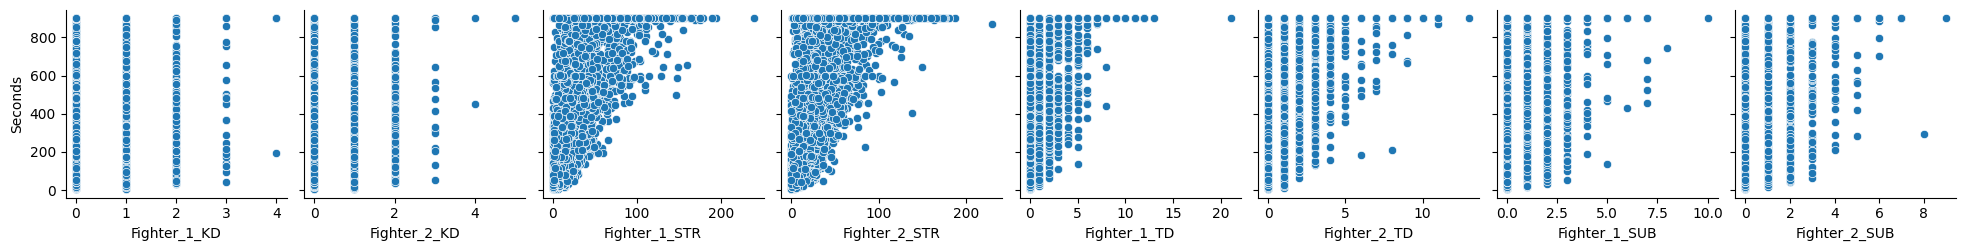

In [149]:
sns.pairplot(winrates_df_for_plot,   x_vars=['Fighter_1_KD', 'Fighter_2_KD','Fighter_1_STR',   'Fighter_2_STR', 'Fighter_1_TD', 'Fighter_2_TD','Fighter_1_SUB', 'Fighter_2_SUB'], y_vars="Seconds")

(0.1, 241.5)

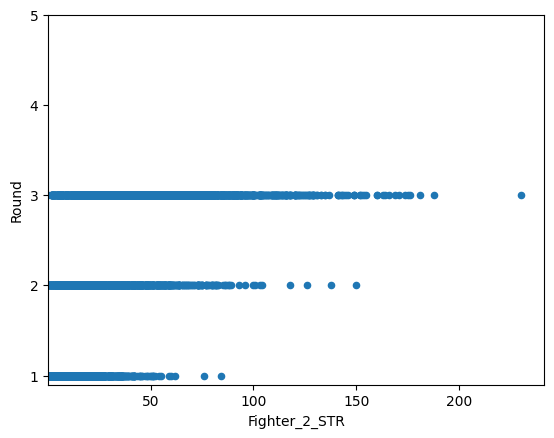

In [150]:
winrates_df_for_plot.plot.scatter(y="Round", x="Fighter_2_STR")
plt.yticks([1,2,3,4,5])
plt.xlim(0.1)

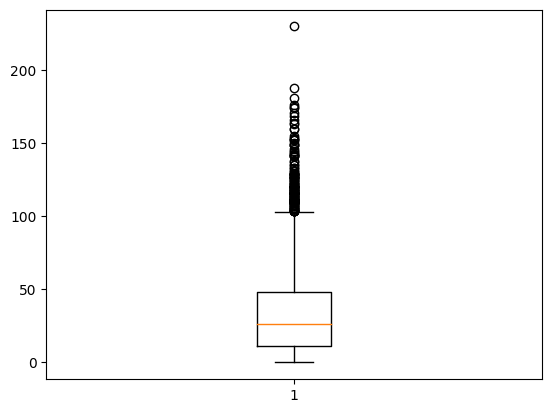

In [151]:
plt.boxplot(winrates_df_for_plot["Fighter_2_STR"])

series = winrates_df_for_plot["Fighter_2_STR"].copy()

In [152]:
check_round_and_str2 = winrates_df_for_plot[['Round', "Fighter_2_STR"]]
check_round_and_str2

,Round,Fighter_2_STR
0,1,2.0
1,1,33.0
2,3,46.0
3,2,14.0
4,3,46.0
...,...,...
6131,2,28.0
6132,1,11.0
6133,2,4.0
6134,1,0.0


<Axes: xlabel='Fighter_2_STR', ylabel='Round'>

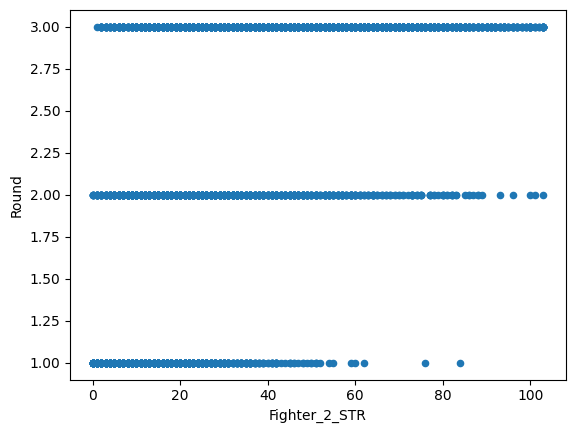

In [153]:
h_outliers, l_outliers = calculate_outliers(check_round_and_str2['Fighter_2_STR'])

without_outliers = check_round_and_str2.loc[check_round_and_str2["Fighter_2_STR"] < h_outliers]

without_outliers.plot.scatter(x="Fighter_2_STR", y="Round")

### REMOVE OUTLIERS

## MEAN OF RESIDUALS

In [154]:
predidted_time = model_Time.fit().predict(winrates_df_model)

residuals = winrates_df["Seconds"] - predidted_time

mean_of_residuals = residuals.sum()/residuals.size

mean_of_residuals

1.490527822853417e-12

OK!

## CHECK FOR HOMOSKEDASTICITY

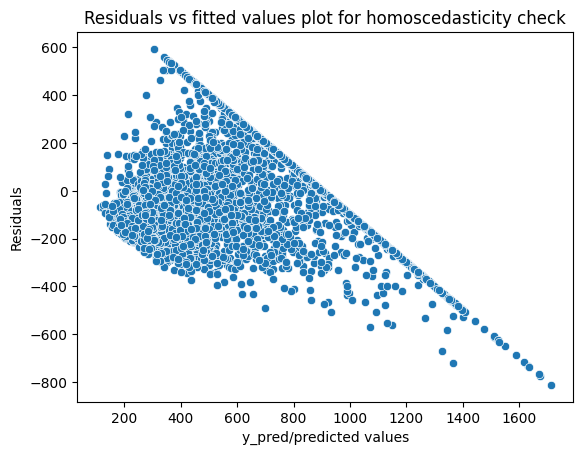

In [155]:
p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

Null Hypothesis: Error terms are homoscedastic

Alternative Hypothesis: Error terms are heteroscedastic.

In [169]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, winrates_df_model)
lzip(name, test)

[('F statistic', 0.9161448814365942), ('p-value', 0.992184554926497)]

We can not reject null hypotheses

In [171]:
bartlett(predictions, residuals) # подумати над цим

BartlettResult(statistic=527.2756368651411, pvalue=1.105736522397429e-116)

In [158]:
het_white(residuals, model_Time.exog)


(1167.375068202247,
 2.1059463273357386e-145,
 7.908633172388839,
 1.6624511766948388e-165)

## NORMALITY

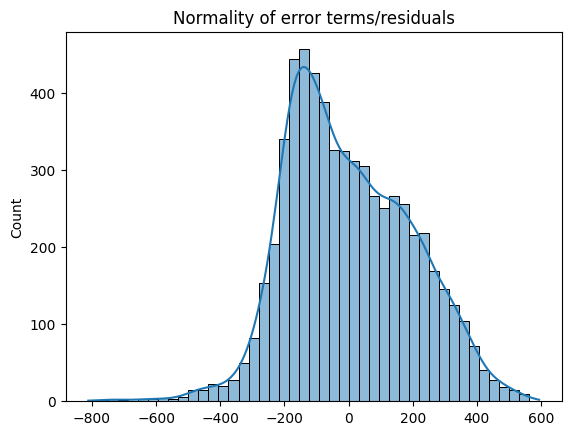

In [159]:
p = sns.histplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

Close to normal

In [160]:
normaltest(residuals)

NormaltestResult(statistic=42.88230027569409, pvalue=4.87783167434213e-10)

Not normal 

# AUTOCORRELATION

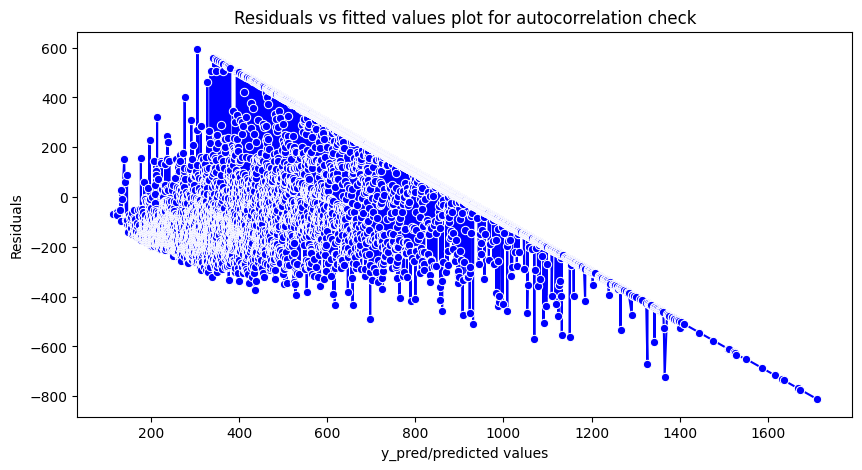

In [161]:
plt.figure(figsize=(10,5))
p = sns.lineplot(y=residuals,x=predidted_time,marker='o',color='blue')
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
p = plt.title('Residuals vs fitted values plot for autocorrelation check')

In [180]:
diag.acorr_ljungbox(residuals, lags=12)

,lb_stat,lb_pvalue
1,8.098857,4.429317e-03
2,23.824636,6.707273e-06
3,24.269304,2.194608e-05
4,39.345143,5.911603e-08
5,44.561680,1.781198e-08
6,48.105723,1.125514e-08
7,48.269821,3.153280e-08
8,51.903658,1.756756e-08
9,59.744868,1.501326e-09
10,65.718673,2.952793e-10


Not autocorrelated

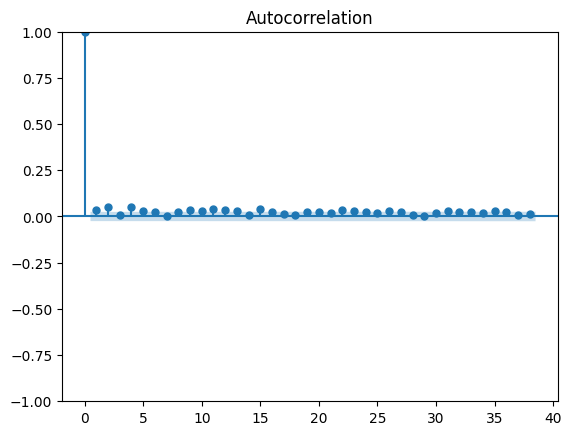

In [163]:
sm.graphics.tsa.plot_acf(residuals)
plt.show()

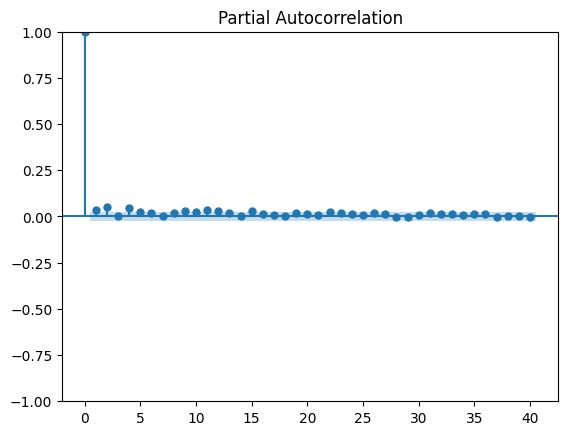

In [164]:
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

## NO PERFECT COLLINEARITY

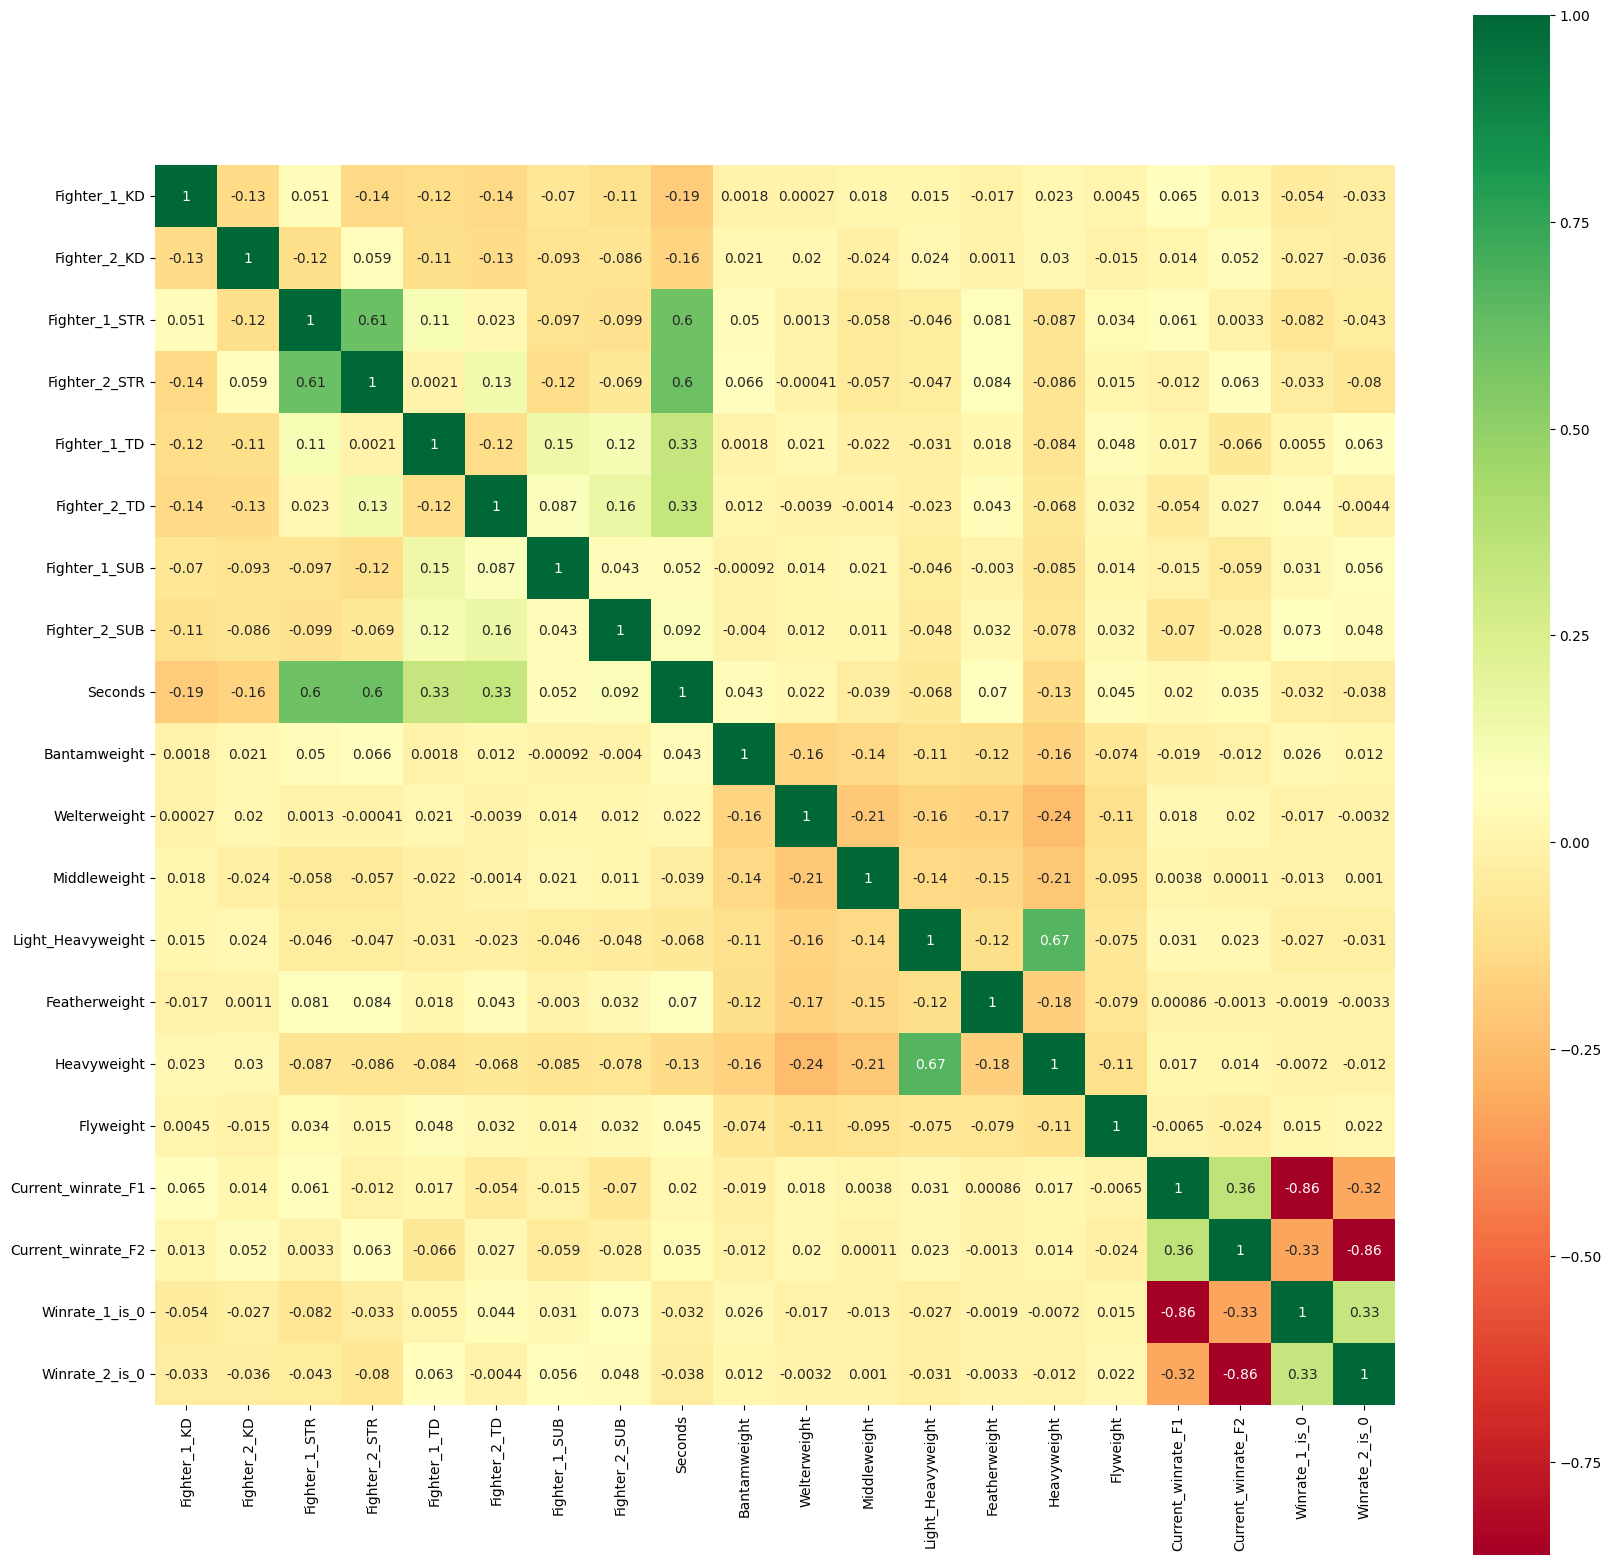

In [181]:
winrates_df_model = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Lightweight'], axis=1).copy()

plt.figure(figsize=(20,20)) 
p=sns.heatmap(winrates_df_model.corr(), annot=True,cmap='RdYlGn',square=True)  

<Axes: >

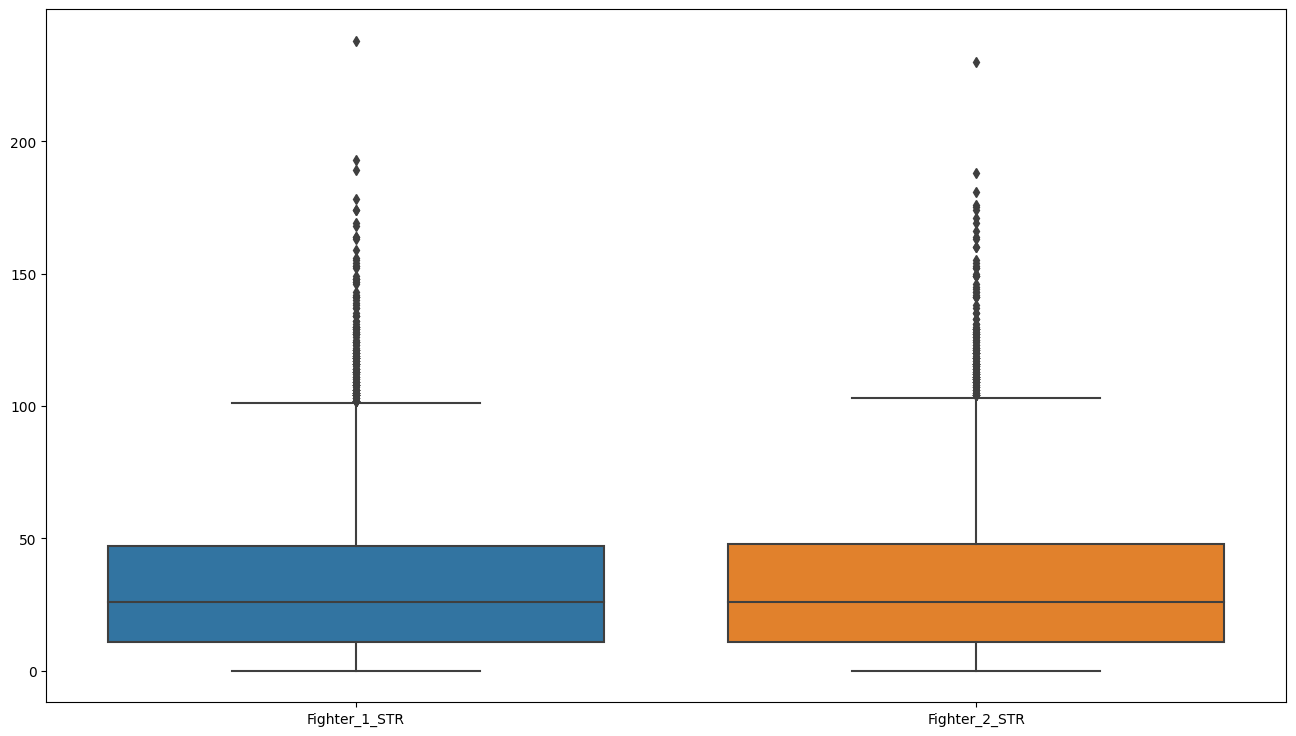

In [187]:
plt.figure(figsize=(16,9))
sns.boxplot(winrates_df_model[['Fighter_1_STR', 'Fighter_2_STR']])

<Axes: >

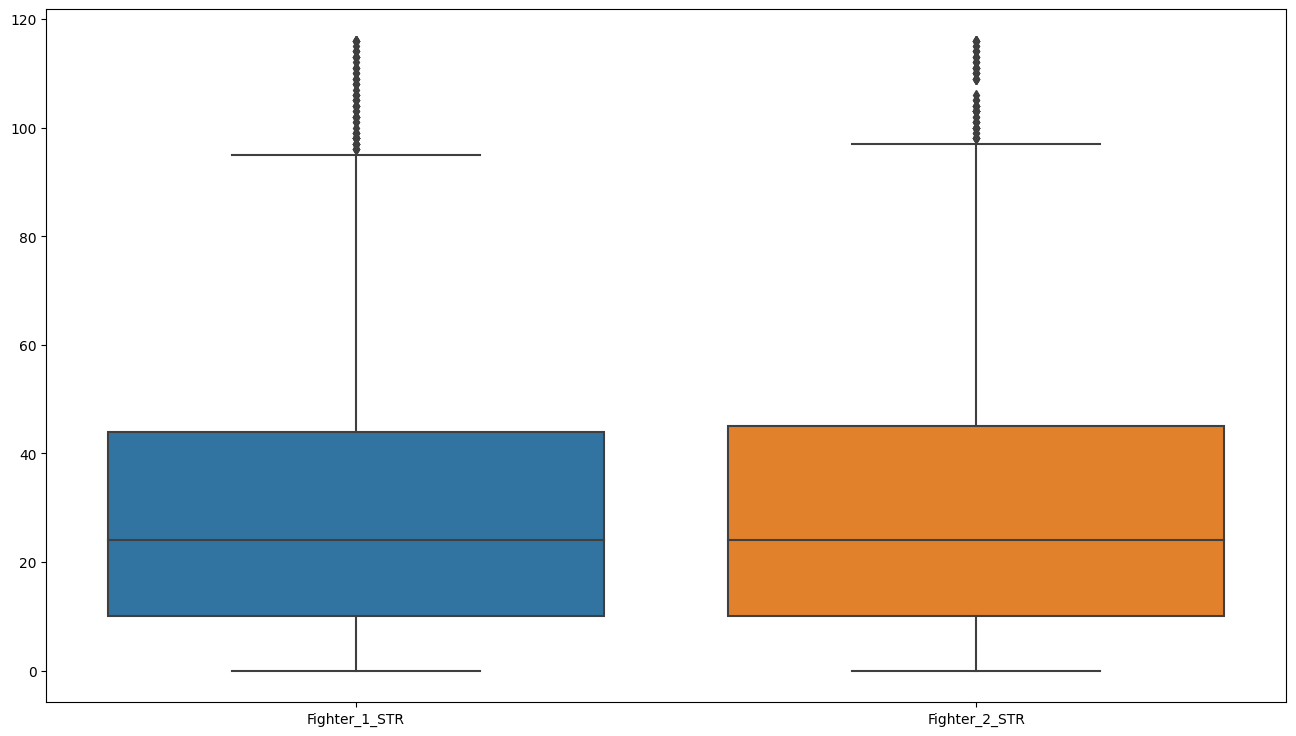

In [197]:
a = winrates_df_model[(np.abs(stats.zscore(winrates_df_model)) < 3).all(axis=1)]

plt.figure(figsize=(16,9))
sns.boxplot(a[['Fighter_1_STR', 'Fighter_2_STR']])

In [200]:
a.reset_index(drop=True)

,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Seconds,Bantamweight,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,64.0,0,0,0,0,0,0,0,0.88,0.77,0,0
1,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,169.0,0,0,0,0,0,0,0,0.59,0.56,0,0
2,0.0,0.0,18.0,14.0,0.0,5.0,0.0,3.0,703.0,0,1,0,0,0,0,0,0.75,0.83,0,0
3,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,900.0,0,0,0,0,0,0,0,0.53,0.56,0,0
4,1.0,0.0,64.0,31.0,4.0,0.0,1.0,0.0,550.0,0,0,1,0,0,0,0,0.20,0.50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4424,0.0,0.0,31.0,11.0,4.0,2.0,0.0,0.0,540.0,0,0,1,0,0,0,0,0.00,0.00,1,1
4425,1.0,0.0,22.0,26.0,0.0,3.0,1.0,0.0,338.0,0,0,0,0,0,1,0,0.00,0.00,1,1
4426,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,43.0,0,0,0,0,0,1,0,0.00,0.00,1,1
4427,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,661.0,0,0,0,0,0,1,0,0.00,0.00,1,1


In [217]:
new_m = smf.ols(f"Seconds ~ {' + '.join(a.drop(['Seconds', 'Bantamweight', 'Flyweight'], axis=1))}", data=a).fit()

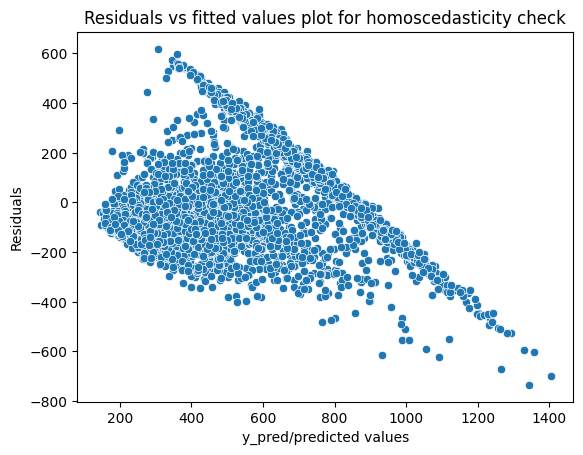

In [219]:
predicted = new_m.predict(a)

residuals = a["Seconds"] - predicted

p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

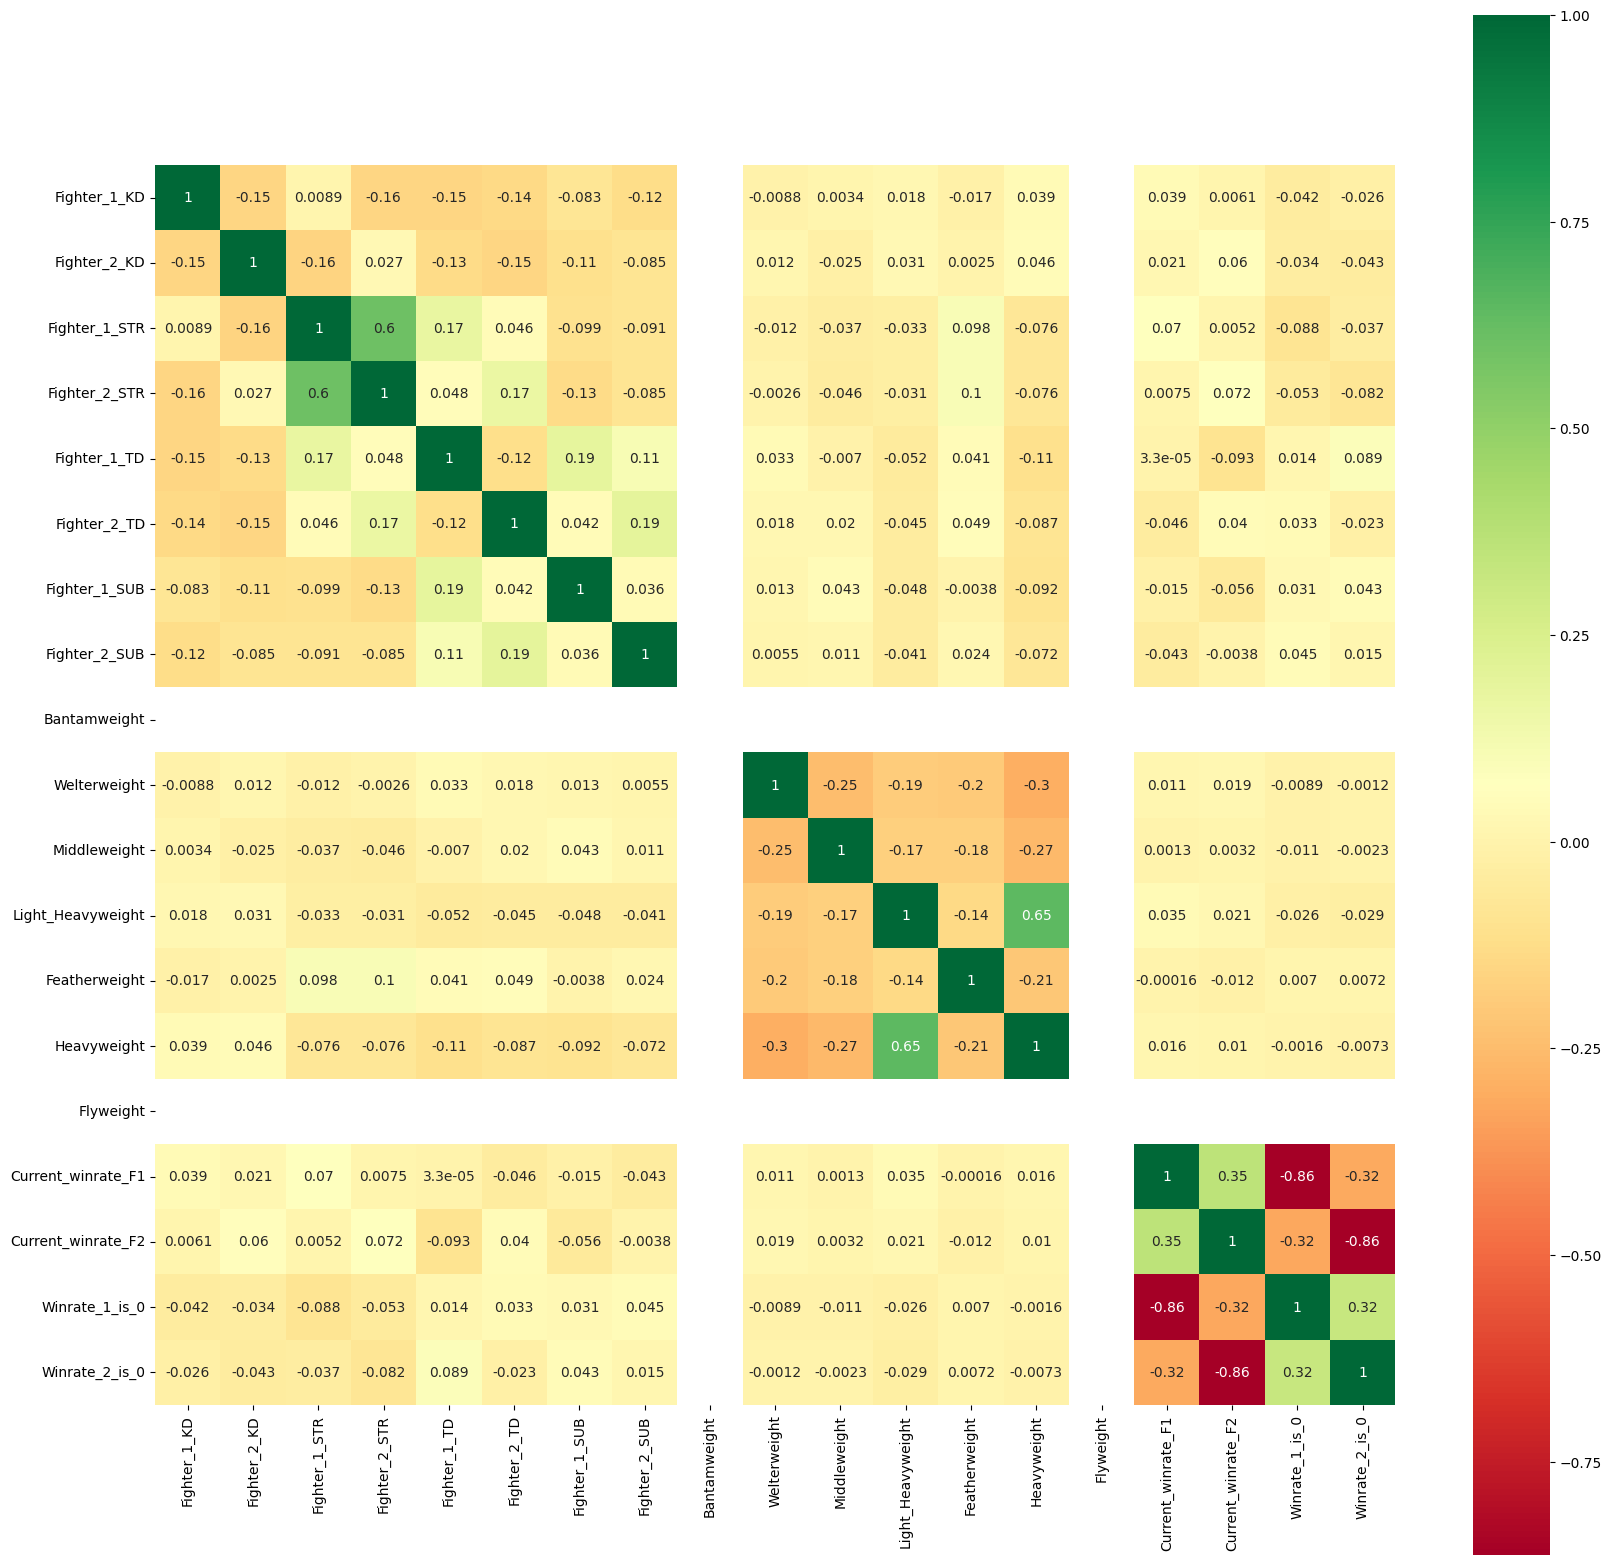

In [212]:
plt.figure(figsize=(20,20))
p=sns.heatmap(a.drop(['Seconds'], axis=1).corr(), annot=True,cmap='RdYlGn',square=True) 
